In [89]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.isotonic import IsotonicRegression

import matplotlib.pyplot as plt

import venn_abers as va
from pygam import LogisticGAM, s

# *Import Datasets*

In [90]:
train_df = pd.read_csv('DATA/preprocessed_train.csv', low_memory=False)
valid_df = pd.read_csv('DATA/preprocessed_valid.csv', low_memory=False)
test_df = pd.read_csv('DATA/preprocessed_test.csv', low_memory=False)

# *Data Preparation for Modeling*

In [91]:
modeling_variables = ['person_income', 'person_home_ownership', 'person_emp_length',
       'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length']

target_variable = 'loan_status'

In [92]:
# Take necessary columns

# Train
X_train = train_df[modeling_variables]
y_train = train_df[target_variable]

# Validation
X_valid = valid_df[modeling_variables]
y_valid = valid_df[target_variable]

# Test
X_test = test_df[modeling_variables]
y_test = test_df[target_variable]

In [93]:
X_train.shape, X_valid.shape, X_test.shape

((20745, 9), (5187, 9), (6484, 9))

# *XGBoost Model*

In [94]:
params =  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0, 'scale_pos_weight': 0.6}

In [95]:
xgb_model = XGBClassifier(**params, n_estimators=50, random_state=0)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [96]:
# Predict
pred_train = xgb_model.predict_proba(X_train)[:, 1]
pred_valid = xgb_model.predict_proba(X_valid)[:, 1]
pred_test = xgb_model.predict_proba(X_test)[:, 1]

In [97]:
# Calculate AUC
print('AUC Train:', roc_auc_score(y_train, pred_train))
print('AUC Valid:', roc_auc_score(y_valid, pred_valid))
print('AUC Test:', roc_auc_score(y_test, pred_test))

AUC Train: 0.9498282014421108
AUC Valid: 0.9396534087889898
AUC Test: 0.9373856786592573


# *Venn-ABERS calibration*

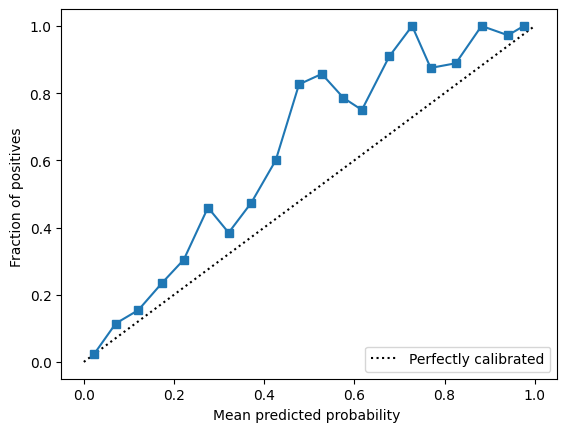

In [98]:
prob_true, prob_pred = calibration_curve(y_valid, pred_valid, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, pred_valid)
disp.plot()

In [99]:
p_cal  = xgb_model.predict_proba(X_valid)
p_test = xgb_model.predict_proba(X_test)

In [100]:
VAC = va.VennAbersCalibrator()
predictions_IVAP, intervals = VAC.predict_proba(p_cal=p_cal, y_cal=y_valid.values, p_test=p_test, p0_p1_output=True)

In [101]:
predictions_IVAP = predictions_IVAP[:,1]

Venn-ABERS predictors perform two [isotonic regressions](https://cseweb.ucsd.edu/~elkan/calibrated.pdf) (using the greatest convex minorant of the cumulative sum diagram), one for for class 0 leading to probabilities $p_0$, and one for class 1 leading to probabilities $p_1$.
$p_0$ and $p_1$ form an interval within which the correct probability is deemed to be located.
A single-valued probability can be obtained by combining these results, for example via

$$    p = \frac{p_1}{1-p_0 + p_1} $$

It is worth mentioning that this technique can also be [extended to multi-class problems](https://proceedings.mlr.press/v60/manokhin17a/manokhin17a.pdf).

We shall make use of the [venn-abers](https://github.com/ip200/venn-abers) package written by Ivan Petej

In [102]:
(intervals[:,1] - intervals[:,0]).max()

0.16384180790960456

In [103]:
intervals[0][1]/ (1- intervals[0][0] + intervals[0][1])

0.0009345794392523365

In [104]:
predictions_IVAP

array([9.34579439e-04, 9.97849462e-01, 2.51365523e-01, ...,
       7.36434109e-02, 1.45714286e-01, 1.45714286e-01])

## GAM calibration

In [106]:
gam = LogisticGAM(s(feature=0, n_splines=20, spline_order=4, by=None, edge_knots=None, basis='ps', dtype='numerical', lam=0.6, penalties='auto', constraints='monotonic_inc'))

gam.fit(p_cal[:,1], y_valid)

cal_test_gam = gam.predict_proba(pred_test)

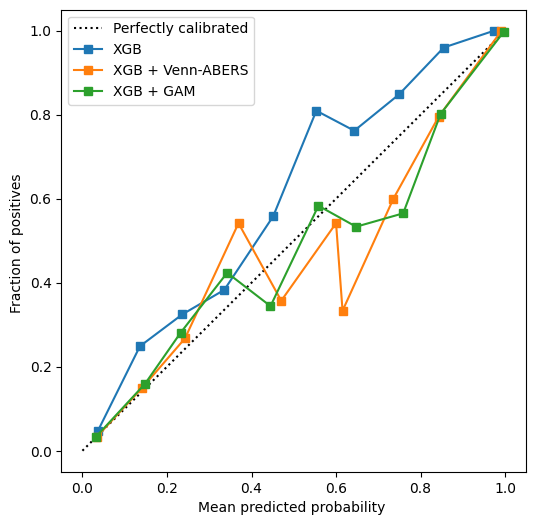

In [107]:
# Compute calibration curves for different models or calibration methods
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, pred_test, n_bins=10)
prob_true_va, prob_pred_va = calibration_curve(y_test, predictions_IVAP, n_bins=10)
prob_true_gam, prob_pred_gam = calibration_curve(y_test, cal_test_gam, n_bins=10)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot calibration curves for different models
CalibrationDisplay(prob_true_xgb, prob_pred_xgb, pred_test).plot(ax=ax, label="XGB")
CalibrationDisplay(prob_true_va, prob_pred_va, predictions_IVAP).plot(ax=ax, label="XGB + Venn-ABERS")
CalibrationDisplay(prob_true_gam, prob_pred_gam, cal_test_gam).plot(ax=ax, label="XGB + GAM")

# Add diagonal reference line (perfect calibration)
# ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Perfect Calibration")

# Add legend
ax.legend()
plt.show()

In [108]:
print('Brier Score of XGB: ', brier_score_loss(y_test, pred_test))
print('Brier Score of XGB + Venn-ABERS: ', brier_score_loss(y_test, predictions_IVAP))
print('Brier Score of XGB + Venn-GAM: ', brier_score_loss(y_test, cal_test_gam))

Brier Score of XGB:  0.06176982133006872
Brier Score of XGB + Venn-ABERS:  0.059953219820239476
Brier Score of XGB + Venn-GAM:  0.05982390329597923


In [109]:
test_df['y_pred'] = pred_test
test_df['gam_y_pred'] = cal_test_gam
test_df['calibrated_y_pred'] = predictions_IVAP
test_df['p0'] = intervals[:,0]
test_df['p1'] = intervals[:,1]
test_df['CP_interval_length'] = intervals[:,1] - intervals[:,0]

In [110]:
test_df.sort_values(by='y_pred', ignore_index=True, inplace=True)

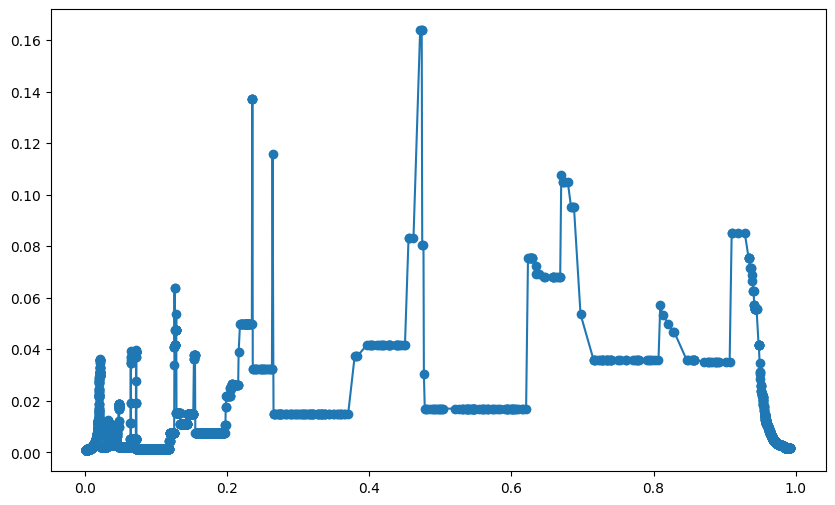

In [111]:
plt.figure(figsize=(10,6))
plt.scatter(test_df['y_pred'], test_df['CP_interval_length'])
plt.plot(test_df['y_pred'], test_df['CP_interval_length'])

In [112]:
test_df.sort_values(by='CP_interval_length', ascending=False)

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,ID,y_pred,gam_y_pred,calibrated_y_pred,p0,p1,CP_interval_length
5490,46000.0,3,3.0,4,4,11000,1,0.24,2,3,3395,0.473785,0.743823,0.713592,0.666667,0.830508,0.163842
5491,50000.0,2,5.0,4,4,6000,0,0.12,2,16,30114,0.473999,0.744250,0.713592,0.666667,0.830508,0.163842
5489,82000.0,2,13.0,4,5,26800,0,0.33,2,15,31076,0.471765,0.739749,0.713592,0.666667,0.830508,0.163842
5370,34000.0,3,5.0,4,2,1200,1,0.04,1,4,1472,0.235904,0.336238,0.340426,0.250000,0.387097,0.137097
5369,44000.0,3,10.0,3,3,8000,0,0.18,1,3,8869,0.235869,0.336167,0.340426,0.250000,0.387097,0.137097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,61450.0,1,6.0,1,1,12500,0,0.20,1,16,30535,0.001622,0.005388,0.000782,0.000000,0.000783,0.000783
5,47000.0,1,8.0,1,1,6000,0,0.13,1,5,21202,0.001639,0.005394,0.000782,0.000000,0.000783,0.000783
6,50000.0,1,3.0,1,1,6000,0,0.12,1,4,17526,0.001639,0.005394,0.000782,0.000000,0.000783,0.000783
7,57600.0,1,6.0,1,1,6500,0,0.11,1,3,8394,0.001639,0.005394,0.000782,0.000000,0.000783,0.000783


In [113]:
test_df['RISK_BIN'] = pd.qcut(test_df['y_pred'], q=10, labels=False) + 1

In [114]:
test_df_grp = test_df.groupby('RISK_BIN')[['y_pred','gam_y_pred', 'calibrated_y_pred', 'loan_status']].mean().reset_index()

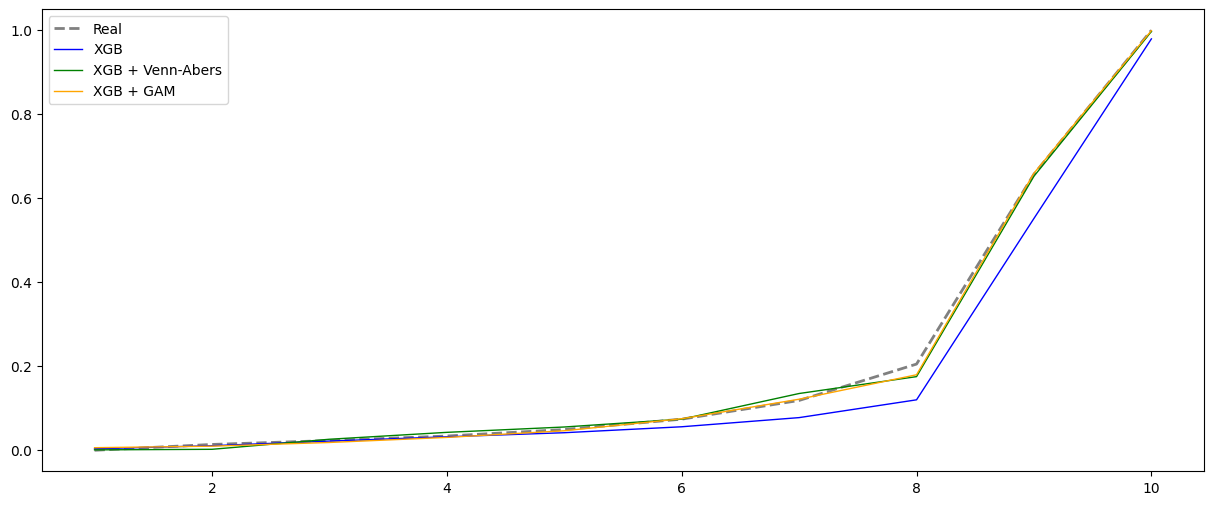

In [115]:
plt.figure(figsize=(15,6))
plt.plot(test_df_grp['RISK_BIN'], test_df_grp['loan_status'],linestyle='dashed', linewidth=2, label='Real', color='grey')
plt.plot(test_df_grp['RISK_BIN'], test_df_grp['y_pred'], linewidth=1, label='XGB', color='blue')
plt.plot(test_df_grp['RISK_BIN'], test_df_grp['calibrated_y_pred'],linewidth=1,  label='XGB + Venn-Abers', color='green')
plt.plot(test_df_grp['RISK_BIN'], test_df_grp['gam_y_pred'],linewidth=1,  label='XGB + GAM', color='orange')
plt.legend()

In [124]:
high_risk = test_df[test_df['RISK_BIN']==9]

<Axes: >

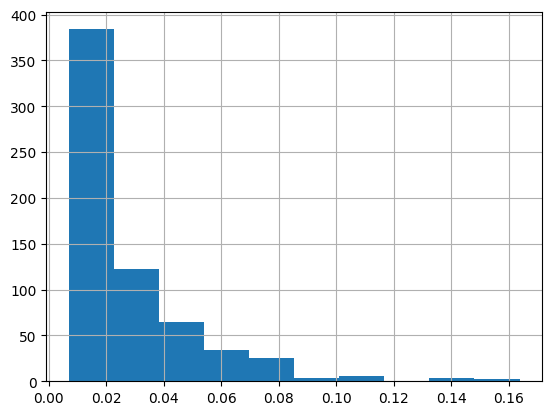

In [125]:
high_risk['CP_interval_length'].hist()

In [129]:
high_risk[high_risk['CP_interval_length']>0.08]['loan_status'].mean()

0.6153846153846154

In [130]:
high_risk[high_risk['CP_interval_length']<=0.04]['loan_status'].mean()

0.6535433070866141

In [133]:
test_df[test_df['RISK_BIN']>=9]['calibrated_y_pred'].min()

0.25136552326851647

In [134]:
acc = test_df[test_df['RISK_BIN']<9]
rej = test_df[test_df['RISK_BIN']>=9]

In [141]:
acc[acc['p1']>=0.251]['loan_status'].mean()

0.25925925925925924

In [143]:
rej[rej['p0']<0.251]['loan_status'].mean()

0.31891891891891894

<Axes: >

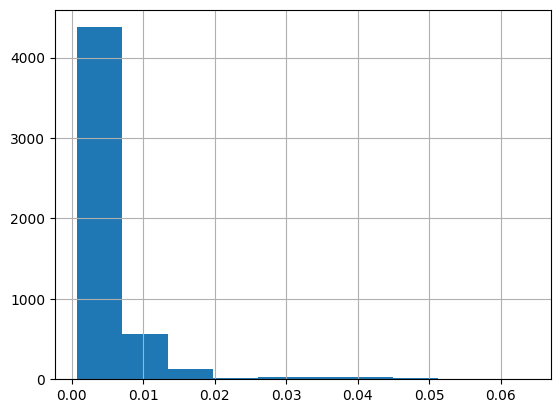

In [145]:
acc['CP_interval_length'].hist()

In [149]:
acc[acc['CP_interval_length']>=0.02]['loan_status'].mean()

0.09016393442622951

In [150]:
acc[acc['CP_interval_length']<0.02]['loan_status'].mean()

0.06416584402764067

# *Implementation of Vann-ABERS From Scratch*

In [28]:
valid_df

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,ID,y_pred_0,y_pred_1
0,39000.0,3,3.0,4,2,8000,1,0.21,1,3,8881,0.826349,0.173651
1,41000.0,3,3.0,5,3,7000,0,0.17,2,5,22262,0.866372,0.133628
2,36996.0,3,8.0,3,3,9600,0,0.26,2,4,10162,0.877720,0.122280
3,225000.0,3,13.0,2,3,12025,0,0.01,1,30,32333,0.960635,0.039365
4,105000.0,2,8.0,1,1,10000,0,0.10,1,3,14369,0.995643,0.004357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5182,140000.0,2,5.0,4,2,20000,0,0.14,1,9,27331,0.950190,0.049810
5183,45000.0,2,6.0,5,1,10000,0,0.22,1,10,20888,0.962147,0.037853
5184,200000.0,2,4.0,3,3,3000,0,0.01,1,3,198,0.949071,0.050929
5185,48000.0,2,4.0,3,1,6500,0,0.14,1,2,6126,0.943788,0.056212


In [37]:
train_df['y_pred_0'] = xgb_model.predict_proba(X_train)[:, 0]
train_df['y_pred_1'] = xgb_model.predict_proba(X_train)[:, 1]

valid_df['y_pred_0'] = xgb_model.predict_proba(X_valid)[:, 0]
valid_df['y_pred_1'] = xgb_model.predict_proba(X_valid)[:, 1]

test_df['y_pred_0'] = xgb_model.predict_proba(X_test)[:, 0]
test_df['y_pred_1'] = xgb_model.predict_proba(X_test)[:, 1]

In [38]:
ir_0 = IsotonicRegression()
ir_1 = IsotonicRegression()

In [39]:
p_cal_0 = valid_df.loc[valid_df['loan_status'] == 0, 'y_pred_0']
y_cal_0 = valid_df.loc[valid_df['loan_status'] == 0, 'loan_status']

p_cal_1 = valid_df.loc[valid_df['loan_status'] == 1, 'y_pred_1']
y_cal_1 = valid_df.loc[valid_df['loan_status'] == 1, 'loan_status']

In [40]:
ir_0.fit(p_cal_0, y_cal_0)
ir_1.fit(p_cal_1, y_cal_1)

IsotonicRegression()

In [41]:
prob_0 = ir_0.transform(p_cal_0)  # Calibrated probs for class 0
prob_1 = ir_1.transform(p_cal_1)  # Calibrated probs for class 1

In [35]:
prob_0

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [36]:
prob_1

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [44]:
p_cal_0 = valid_df.loc[valid_df['loan_status'] == 0, 'y_pred_0']
y_cal_0 = valid_df.loc[valid_df['loan_status'] == 0, 'loan_status']

p_cal_1 = valid_df.loc[valid_df['loan_status'] == 1, 'y_pred_1']
y_cal_1 = valid_df.loc[valid_df['loan_status'] == 1, 'loan_status']

ir_0.fit(p_cal_0, y_cal_0)
ir_1.fit(p_cal_1, y_cal_1)

IsotonicRegression()

In [45]:
g_0 = IsotonicRegression()
g_1 = IsotonicRegression()

p_cal = valid_df['y_pred']  # Use full dataset predictions
y_cal = valid_df['loan_status']  # True labels

g_0.fit(p_cal, (y_cal == 0).astype(int))  # Class 0 calibration
g_1.fit(p_cal, (y_cal == 1).astype(int))  # Class 1 calibration

prob_0 = g_0.predict(valid_df['y_pred'])
prob_1 = g_1.predict(valid_df['y_pred'])


KeyError: 'y_pred'

In [86]:
p_cal[:, 1].reshape(-1, 1)

array([[0.17365061],
       [0.13362758],
       [0.12227967],
       ...,
       [0.05092907],
       [0.05621203],
       [0.9705132 ]], dtype=float32)

In [87]:
p_cal

array([[0.8263494 , 0.17365061],
       [0.8663724 , 0.13362758],
       [0.87772036, 0.12227967],
       ...,
       [0.94907093, 0.05092907],
       [0.943788  , 0.05621203],
       [0.02948678, 0.9705132 ]], dtype=float32)

In [90]:
np.hstack((p_cal[:, 1].reshape(-1, 1), y_valid.values.reshape(-1, 1)))

array([[0.17365061, 1.        ],
       [0.13362758, 0.        ],
       [0.12227967, 0.        ],
       ...,
       [0.05092907, 0.        ],
       [0.05621203, 0.        ],
       [0.97051322, 1.        ]])

In [93]:
cal = np.hstack((p_cal[:, 1].reshape(-1, 1), y_valid.values.reshape(-1, 1)))

In [200]:
ix = np.argsort(cal[:, 0])
k_sort = cal[ix, 0]
k_label_sort = cal[ix, 1]

c = np.unique(k_sort)
ia = np.searchsorted(k_sort, c)

w = np.zeros(len(c))

w[:-1] = np.diff(ia)
w[-1] = len(k_sort) - ia[-1]

k_dash = len(c)
P = np.zeros((k_dash + 2, 2))

P[0, :] = -1

P[2:, 0] = np.cumsum(w)
P[2:-1, 1] = np.cumsum(k_label_sort)[(ia - 1)[1:]]
P[-1, 1] = np.cumsum(k_label_sort)[-1]

p1 = np.zeros((len(c) + 1, 2))
p1[1:, 0] = c

P1 = P[1:] + 1

In [231]:
P[1:]+1

array([[1.000e+00, 1.000e+00],
       [1.400e+01, 1.000e+00],
       [1.500e+01, 1.000e+00],
       ...,
       [5.186e+03, 1.106e+03],
       [5.187e+03, 1.107e+03],
       [5.188e+03, 1.108e+03]])

In [225]:
p1

array([[0.        , 0.        ],
       [0.00184519, 0.        ],
       [0.0018601 , 0.        ],
       ...,
       [0.99242216, 0.        ],
       [0.99269766, 0.        ],
       [0.99373722, 0.        ]])

In [226]:
P1

array([[1.000e+00, 1.000e+00],
       [1.400e+01, 1.000e+00],
       [1.500e+01, 1.000e+00],
       ...,
       [5.186e+03, 1.106e+03],
       [5.187e+03, 1.107e+03],
       [5.188e+03, 1.108e+03]])

In [ ]:
if precision is not None:
    cal = np.hstack((np.round(p_cal[:, 1], precision).reshape(-1, 1), y_cal.reshape(-1, 1)))
else:
    cal = np.hstack((p_cal[:, 1].reshape(-1, 1), y_cal.reshape(-1, 1)))
ix = np.argsort(cal[:, 0])
k_sort = cal[ix, 0]
k_label_sort = cal[ix, 1]

c = np.unique(k_sort)
ia = np.searchsorted(k_sort, c)

w = np.zeros(len(c))

w[:-1] = np.diff(ia)
w[-1] = len(k_sort) - ia[-1]

k_dash = len(c)
P = np.zeros((k_dash + 2, 2))

P[0, :] = -1

P[2:, 0] = np.cumsum(w)
P[2:-1, 1] = np.cumsum(k_label_sort)[(ia - 1)[1:]]
P[-1, 1] = np.cumsum(k_label_sort)[-1]

p1 = np.zeros((len(c) + 1, 2))
p1[1:, 0] = c

P1 = P[1:] + 1

for i in range(len(p1)):

    P1[i, :] = P1[i, :] - 1

    if i == 0:
        grads = np.divide(P1[:, 1], P1[:, 0])
        grad = np.nanmin(grads)
        p1[i, 1] = grad
        c_point = 0
    else:
        imp_point = P1[c_point, 1] + (P1[i, 0] - P1[c_point, 0]) * grad

        if P1[i, 1] < imp_point:
            grads = np.divide((P1[i:, 1] - P1[i, 1]), (P1[i:, 0] - P1[i, 0]))
            if np.sum(np.isnan(np.nanmin(grads))) == 0:
                grad = np.nanmin(grads)
            c_point = i
            p1[i, 1] = grad
        else:
            p1[i, 1] = grad

p0 = np.zeros((len(c) + 1, 2))
p0[1:, 0] = c

P0 = P[1:]

for i in range(len(p1) - 1, -1, -1):
    P0[i, 0] = P0[i, 0] + 1

    if i == len(p1) - 1:
        grads = np.divide((P0[:, 1] - P0[i, 1]), (P0[:, 0] - P0[i, 0]))
        grad = np.nanmax(grads)
        p0[i, 1] = grad
        c_point = i
    else:
        imp_point = P0[c_point, 1] + (P0[i, 0] - P0[c_point, 0]) * grad

        if P0[i, 1] < imp_point:
            grads = np.divide((P0[:, 1] - P0[i, 1]), (P0[:, 0] - P0[i, 0]))
            grads[i:] = 0
            grad = np.nanmax(grads)
            c_point = i
            p0[i, 1] = grad
        else:
            p0[i, 1] = grad


In [247]:
from sklearn.isotonic import IsotonicRegression

# Data for positive class
X_pos = [0.1, 0.3, 0.5, 0.7, 0.9]  # Predicted probabilities
y_pos = [0, 1, 0, 1, 1]             # True labels

# Fit isotonic regression (non-decreasing)
iso_pos = IsotonicRegression(out_of_bounds="clip")
iso_pos.fit(X_pos, y_pos)

# Calibrated probabilities for positive class
p1 = iso_pos.transform(X_pos)

In [248]:
p1

array([0. , 0.5, 0.5, 1. , 1. ])

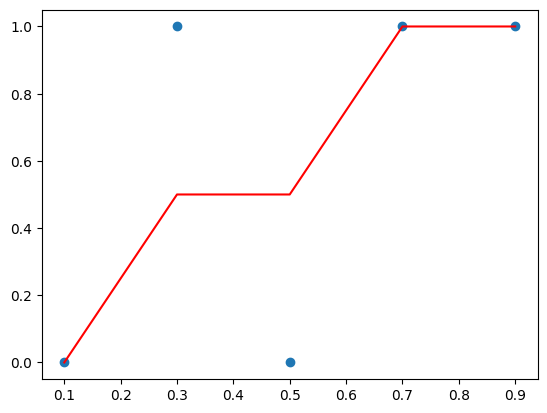

In [249]:
plt.scatter(X_pos, y_pos)
plt.plot(X_pos, p1, color='red')

In [255]:
# Data for negative class
X_neg = [0.1, 0.3, 0.5, 0.7, 0.9]  # Predicted probabilities
y_neg = [1, 0, 1, 0, 0]             # Inverted true labels (1 - y_cal)

# Fit isotonic regression (non-increasing)
iso_neg = IsotonicRegression(increasing=False, out_of_bounds="clip")
iso_neg.fit(X_neg, y_neg)

# Calibrated probabilities for negative class
p0 = iso_neg.transform(X_neg)

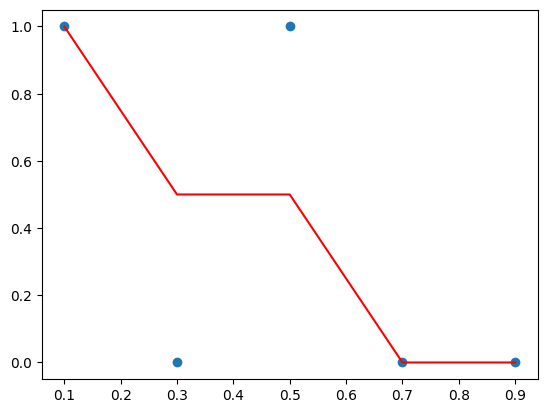

In [256]:
plt.scatter(X_neg, y_neg)
plt.plot(X_neg, p0, color='red')

Brier Score (Uncalibrated): 0.0816
Brier Score (Calibrated - Van Abbe): 0.0000


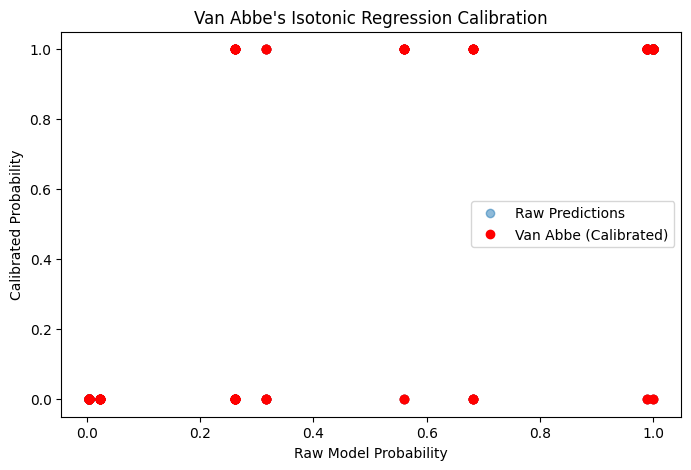

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import brier_score_loss

# Generate synthetic binary classification data
np.random.seed(42)
X = np.random.randn(1000, 2)  # Two features
y = (X[:, 0] + X[:, 1] > 0).astype(int)  # Binary labels

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier (uncalibrated)
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Get raw probability predictions
y_scores = clf.predict_proba(X_test)[:, 1]  # Probability of class 1

# Separate data based on true class
scores_0 = y_scores[y_test == 0]  # Scores where actual label is 0
scores_1 = y_scores[y_test == 1]  # Scores where actual label is 1

# Fit isotonic regression for both classes
iso_reg_0 = IsotonicRegression(out_of_bounds="clip")  # For class 0
iso_reg_1 = IsotonicRegression(out_of_bounds="clip")  # For class 1

# Get calibrated probabilities
prob_0 = iso_reg_0.fit_transform(scores_0, np.zeros_like(scores_0))  # Map scores to P(Y=0)
prob_1 = iso_reg_1.fit_transform(scores_1, np.ones_like(scores_1))   # Map scores to P(Y=1)

# Merge results back into test set
calibrated_probs = np.zeros_like(y_scores)
calibrated_probs[y_test == 0] = prob_0
calibrated_probs[y_test == 1] = prob_1

# Normalize to ensure P(Y=1) + P(Y=0) = 1
calibrated_probs = calibrated_probs / (calibrated_probs + (1 - calibrated_probs))

# Compute Brier score (lower is better)
brier_uncalibrated = brier_score_loss(y_test, y_scores)
brier_calibrated = brier_score_loss(y_test, calibrated_probs)

print(f"Brier Score (Uncalibrated): {brier_uncalibrated:.4f}")
print(f"Brier Score (Calibrated - Van Abbe): {brier_calibrated:.4f}")

# Plot original vs calibrated probabilities
plt.figure(figsize=(8, 5))
plt.plot(y_scores, y_test, 'o', label="Raw Predictions", alpha=0.5)
plt.plot(y_scores, calibrated_probs, 'ro', label="Van Abbe (Calibrated)")
plt.xlabel("Raw Model Probability")
plt.ylabel("Calibrated Probability")
plt.title("Van Abbe's Isotonic Regression Calibration")
plt.legend()
plt.show()


In [84]:
from sklearn.isotonic import IsotonicRegression

# Example data
X = [0.1, 0.2, 0.3, 0.4, 0.5]
y = [0.2, 0.3, 0.1, 0.1, 0.5]

# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(X, y)

# Predict
y_pred = iso_reg.transform(X)

In [ ]:
0.2, 0.2, 0.2, 0.1, 0.5
0.2, 0.2, 0.15, 0.15, 0.5
0.2, 0.175, 0.175, 0.15, 0.5

In [83]:
(0.2 + 0.15)/2

0.175

In [80]:
y_pred

array([0.175, 0.175, 0.175, 0.175, 0.5  ])

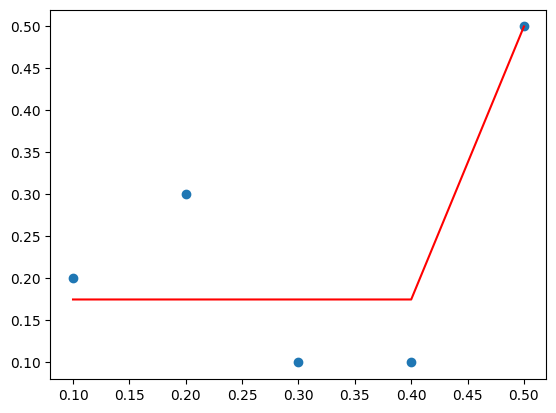

In [81]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')